# Distributional Counterfactual Explanation

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

from models.mlp import BlackBoxModel

pd.set_option('display.max_columns', None)

%reload_ext autoreload
%autoreload 2

## Read and Process Data

In [10]:
df_ = pd.read_csv('data/hotel_booking/hotel_bookings.csv')
df = df_.copy()
target_name = 'is_canceled'
target = df[target_name]

In [11]:
# Initialize a label encoder
label_encoder = LabelEncoder()
label_mappings = {}


# Convert categorical columns to numerical representations using label encoding
for column in df.columns:
    if df[column].dtype == 'object':
        # Handle missing values by filling with a placeholder and then encoding
        df[column] = df[column].fillna('Unknown')
        df[column] = label_encoder.fit_transform(df[column])
        label_mappings[column] = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))


# For columns with NaN values that are numerical, we will impute them with the median of the column
for column in df.columns:
    if df[column].isna().any():
        median_val = df[column].median()
        df[column].fillna(median_val, inplace=True)

# Display the first few rows of the transformed dataframe
df.head()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,1,0,342,2015,5,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,3,0,14.0,179.0,0,2,0.0,0,0,1,15
1,1,0,737,2015,5,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,4,0,14.0,179.0,0,2,0.0,0,0,1,15
2,1,0,7,2015,5,27,1,0,1,1,0.0,0,0,59,3,1,0,0,0,0,2,0,0,14.0,179.0,0,2,75.0,0,0,1,46
3,1,0,13,2015,5,27,1,0,1,1,0.0,0,0,59,2,0,0,0,0,0,0,0,0,304.0,179.0,0,2,75.0,0,0,1,46
4,1,0,14,2015,5,27,1,0,2,2,0.0,0,0,59,6,3,0,0,0,0,0,0,0,240.0,179.0,0,2,98.0,0,1,1,76


## Model Training

In [12]:
features = [
    # 'hotel', 
    'lead_time', 
    # 'arrival_date_year', 
    # 'arrival_date_month',
    # 'arrival_date_week_number', 
    # 'arrival_date_day_of_month',
    # 'stays_in_weekend_nights', 
    # 'stays_in_week_nights', 
    # 'adults', 
    # 'children',
    # 'babies', 
    # 'meal', 
    # 'country', 
    # 'market_segment', 
    # 'distribution_channel',
    # 'is_repeated_guest', 
    # 'previous_cancellations',
    # 'previous_bookings_not_canceled', 
    # 'reserved_room_type',
    # 'assigned_room_type', 
    'booking_changes', 
    # 'deposit_type', 
    # 'agent',
    # 'company', 
    # 'days_in_waiting_list', 
    # 'customer_type', 
    # 'adr',
    # 'required_car_parking_spaces', 
    # 'total_of_special_requests'
]

df_X = df[features].copy()
df_y = target

In [13]:
seed = 42

np.random.seed(seed)  # for reproducibility


# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=seed)

std = X_train.std()
mean = X_train.mean()

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)

# Initialize the model, loss function, and optimizer
model = BlackBoxModel(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

    # Convert outputs to binary using 0.5 as threshold
    y_pred_tensor = (test_outputs > 0.5).float()
    correct_predictions = (y_pred_tensor == y_test_tensor).float().sum()
    accuracy = correct_predictions / y_test_tensor.shape[0]

accuracy.item()

0.6767736077308655

## Counterfactual Explanation

In [209]:
sample_num = 100

indice = (X_test.sample(sample_num)).index

In [214]:
X = X_test.loc[indice].values
y = model(torch.FloatTensor(X))

y_target = torch.distributions.beta.Beta(0.1, 0.9).sample((sample_num,))

y_true = y_test.loc[indice]

delta = 0.2

In [215]:
from explainers.dce import DistributionalCounterfactualExplainer

explainer = DistributionalCounterfactualExplainer(
    model=model, 
    X=X, 
    y_target=y_target, 
    lr=1e-1, 
    epsilon=0.5, 
    lambda_val=100, 
    delta=delta)

In [216]:
np.sqrt(explainer.wd.distance(y, y_target, delta=delta)[0].item())

0.38203483533054466

In [217]:
explainer.wd.distance_interval(y, y_target, delta=delta)

(0.1958103394186153, 0.5249127054300693)

In [25]:
explainer.optimize_without_chance_constraints(max_iter=20)

In [26]:
factual_X = df[df_X.columns].loc[indice].copy()
counterfactual_X = pd.DataFrame(explainer.best_X.detach().numpy() * std[df_X.columns].values + mean[df_X.columns].values, columns=df_X.columns)
# counterfactual_X = pd.DataFrame(explainer.best_X.detach().numpy(), columns=df_X.columns)

factual_y = pd.DataFrame(y.detach().numpy(),columns=[target_name], index=factual_X.index)
counterfactual_y = pd.DataFrame(explainer.best_y.detach().numpy(),columns=[target_name], index=factual_X.index)

In [27]:
pd.DataFrame({
    'factual_y': factual_y[target_name].values,
    'counterfactual_y': counterfactual_y[target_name].values,
})

,factual_y,counterfactual_y
0,0.235751,0.233332
1,0.097682,0.099221
2,0.180850,0.155664
3,0.241555,0.154790
4,0.337813,0.175436
5,0.201052,0.154773
6,0.536360,0.441251
7,0.125254,0.127181
8,0.213961,0.153325
9,0.314806,0.171962


In [29]:
counterfactual_X.index = factual_X.index
counterfactual_X[target_name] = counterfactual_y

In [30]:
factual_X[target_name] = factual_y

In [31]:
counterfactual_X

,lead_time,booking_changes,is_canceled
94640,170.598905,1.016211,0.233332
99873,55.604079,1.993839,0.099221
91063,-7.778241,-0.013318,0.155664
22392,-1.423796,0.068823,0.154790
63729,8.634366,0.098004,0.175436
18652,-5.398643,0.020431,0.154773
69920,154.980322,0.198055,0.441251
106439,14.243497,0.996421,0.127181
28771,-4.727578,0.035627,0.153325
56464,6.271779,0.084309,0.171962


In [32]:
check_column = 'lead_time'
pd.DataFrame({
    'factual': factual_X[check_column].values, 
    'counterfactual': counterfactual_X[check_column].values
    })

,factual,counterfactual
0,161,170.598905
1,54,55.604079
2,2,-7.778241
3,16,-1.423796
4,34,8.634366
5,7,-5.398643
6,169,154.980322
7,13,14.243497
8,10,-4.727578
9,30,6.271779


In [33]:
factual_X[check_column].mean()

109.48333333333333

In [34]:
counterfactual_X[check_column].mean()

96.88942224885798

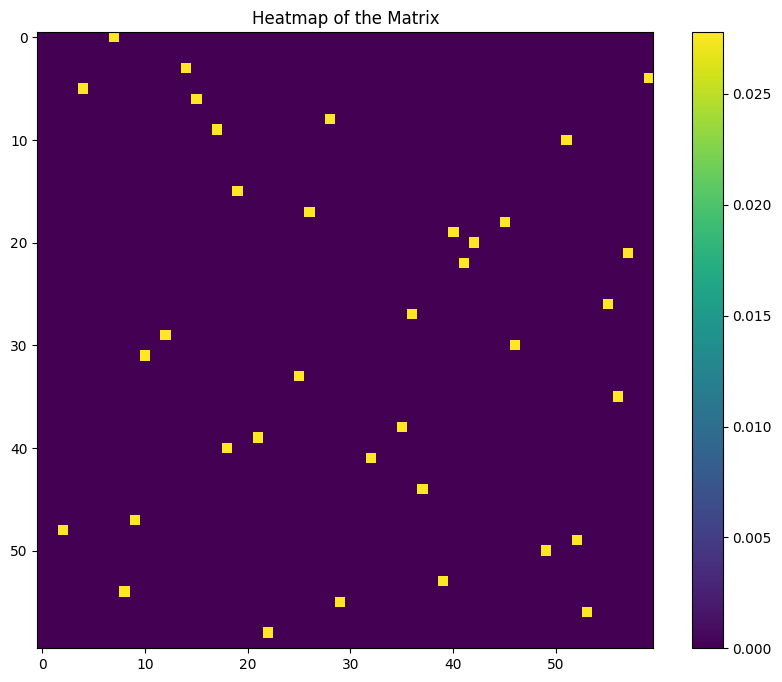

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Sample matrix for demonstration
matrix = explainer.wd.nu.numpy()

plt.figure(figsize=(10, 8))
plt.imshow(matrix, cmap='viridis')
plt.colorbar()
plt.title("Heatmap of the Matrix")
plt.show()
